# Bayesian meta-analysis of two proportions in random control trials (RCTs)
---

This notebook shows how to perform a specific type of meta-analysis in Python/PyMC. The example is adapted from John Kruschke, who originally implemented this analysis in R. Here are links to his [blog entry](http://doingbayesiandataanalysis.blogspot.com/2016/11/bayesian-meta-analysis-of-two.html) and [article](https://link.springer.com/article/10.3758/s13423-016-1221-4).

In this example, we are interested in the number of deaths ("occurrences of mortality") from heart attack in a control group and a treatment group that were "treated" with beta-blockers (a class of drugs that relaxes heart muscles). Let $z_T$ denote the number of occurrences in the treatment group, $n_T$ denote the total number of participants in the treatment group, and $z_C$ and $n_C$ denote the same for the controls. If beta-blockers have a beneficial effect, then $z_T/n_T$ should be less than $z_C/n_C$. 

In a meta-analysis, we are combining information (data) from several studies examining the same phenomenon in order to make better inferences. The data from study $s$ are denoted $z_{C[s]}$, $n_{C[s]}$, etc. The key insight is that even though we don't expect the proportions of occurrences to be the identical across different studies/sites, as each site has its own attributes, we do expect the studies to be similar and mutually informative. That is, we expect Study A to tell us something about Study B, and vice versa. This means we should treat the data from different sites as representative of higher-level parameters that describe what is typical across sites and how much variability there is across sites. This approach is referred to as a **random-effects model**. Here are the equations for this model, starting with the likelihoods in the first two lines:

$$z_C \sim \text{Binomial}(\theta_{C[s]}, n_{C[s]})$$
$$z_T \sim \text{Binomial}(\theta_{T[s]}, n_{T[s]})$$
$$\theta_{C[s]} \sim \text{Beta}(\omega_{\theta C})$$
$$\theta_{T[s]} = \text{logistic}(\rho_s + \text{logit}(\theta_{C[s]}))$$
$$\rho_{s} \sim \text{Normal}(\mu_{\rho}, \sigma_{\rho}^2)$$
$$\mu_{\rho} \sim \text{Normal}(0, 100)$$
$$\sigma_{\rho} \sim \text{Gamma}(\alpha=1.64, \beta=0.64)$$

Here, $\rho_s$ is the difference of log-odds between groups, or, the *log odds ratio* across groups: $\rho_s = \text{log}([\theta_{T[s]}/(1 - \theta_{T[s]})]/[\theta_{C[s]}/(1 - \theta_{C[s]})]$. The distribution across $\rho_s$ is described by a normal distribution, parameterized by its mean and SD. Therefore, what we are most interested in is $\mu_{\rho}$, the estimated treatement effect across studies. ***Definitely read the links I've provided for more details.*** 

The data we will model are from 22 studies, involving anywhere between 77 and 3,887 patients. The are described in Gelamn et al.'s *Bayesian Data Analysis, Third Edition*. The treatment group received beta-blockers. If the treatment is effective, the log odds ratio will be less than zero. 

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format = 'retina'
# az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.95
rng = np.random.default_rng(seed=42)

In [3]:
# Data from 22 studies
z_t_obs = [3, 7, 5, 102, 28, 4, 98, 60, 25, 138, 64, 45, 9, 57, 25, 33, 28, 8, 6, 32, 27, 22]
n_t_obs = [38, 114, 69, 1533, 355, 59, 945, 632, 278,1916, 873, 263, 291, 858, 154, 207, 251, 151, 174, 209, 391, 680]
z_c_obs = [3, 14, 11, 127, 27, 6, 152, 48, 37, 188, 52, 47, 16, 45, 31, 38, 12, 6, 3, 40, 43, 39]
n_c_obs = [39, 116, 93, 1520, 365, 52, 939, 471, 282, 1921, 583, 266, 293, 883, 147, 213, 122, 154, 134, 218, 364, 674]

studies = np.linspace(1, N, N).astype(int)

df = pd.DataFrame(
    {"z_t_obs": z_t_obs, 
    "n_t_obs": n_t_obs,
    "z_c_obs": z_c_obs,
    "n_c_obs": n_c_obs}
)


N = len(n_c_obs)
studies = np.linspace(1, N, N).astype(int)


In [4]:
# with pm.Model(coords={"studies": studies}) as model:
with pm.Model() as model:
    
    # Hyper-priors
    mu_rho = pm.Normal("mu_rho", mu=0, sigma=10)
    sd_rho = pm.Gamma("sd_rho", alpha=1.64, beta=0.64)  # mode=1, sd=2

    omega_theta_c = pm.Beta("omega_theta_c", alpha=1.01, beta=1.01)
    kappa_minus_two_theta_c = pm.Gamma("kappa_minus_two_theta_c", alpha=2.618, beta=0.162)  # mode=10, sd=10
    kappa_theta_c = pm.Deterministic("kappa_theta_c", kappa_minus_two_theta_c + 2)

    # Priors
    rho = pm.Normal("rho", mu=mu_rho, sigma=sd_rho, shape=N)
    theta_c = pm.Beta("theta_c", alpha=omega_theta_c * (kappa_theta_c - 2) + 1, 
                      beta=(1 - omega_theta_c) * (kappa_theta_c - 2) + 1, shape=N)
    theta_t = pm.Deterministic("theta_t", pm.invlogit(rho + pm.logit(theta_c)))  # ilogit is logistic

    # Likelihood
    z_t = pm.Binomial('z_t', n_t_obs, theta_t, observed=z_t_obs)
    z_c = pm.Binomial('z_c', n_c_obs, theta_c, observed=z_c_obs)
    
    # Sample from the posterior
    model, idata = pm.sample(target_accept=0.90)
        

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_rho, sd_rho, omega_theta_c, kappa_minus_two_theta_c, rho, theta_c]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


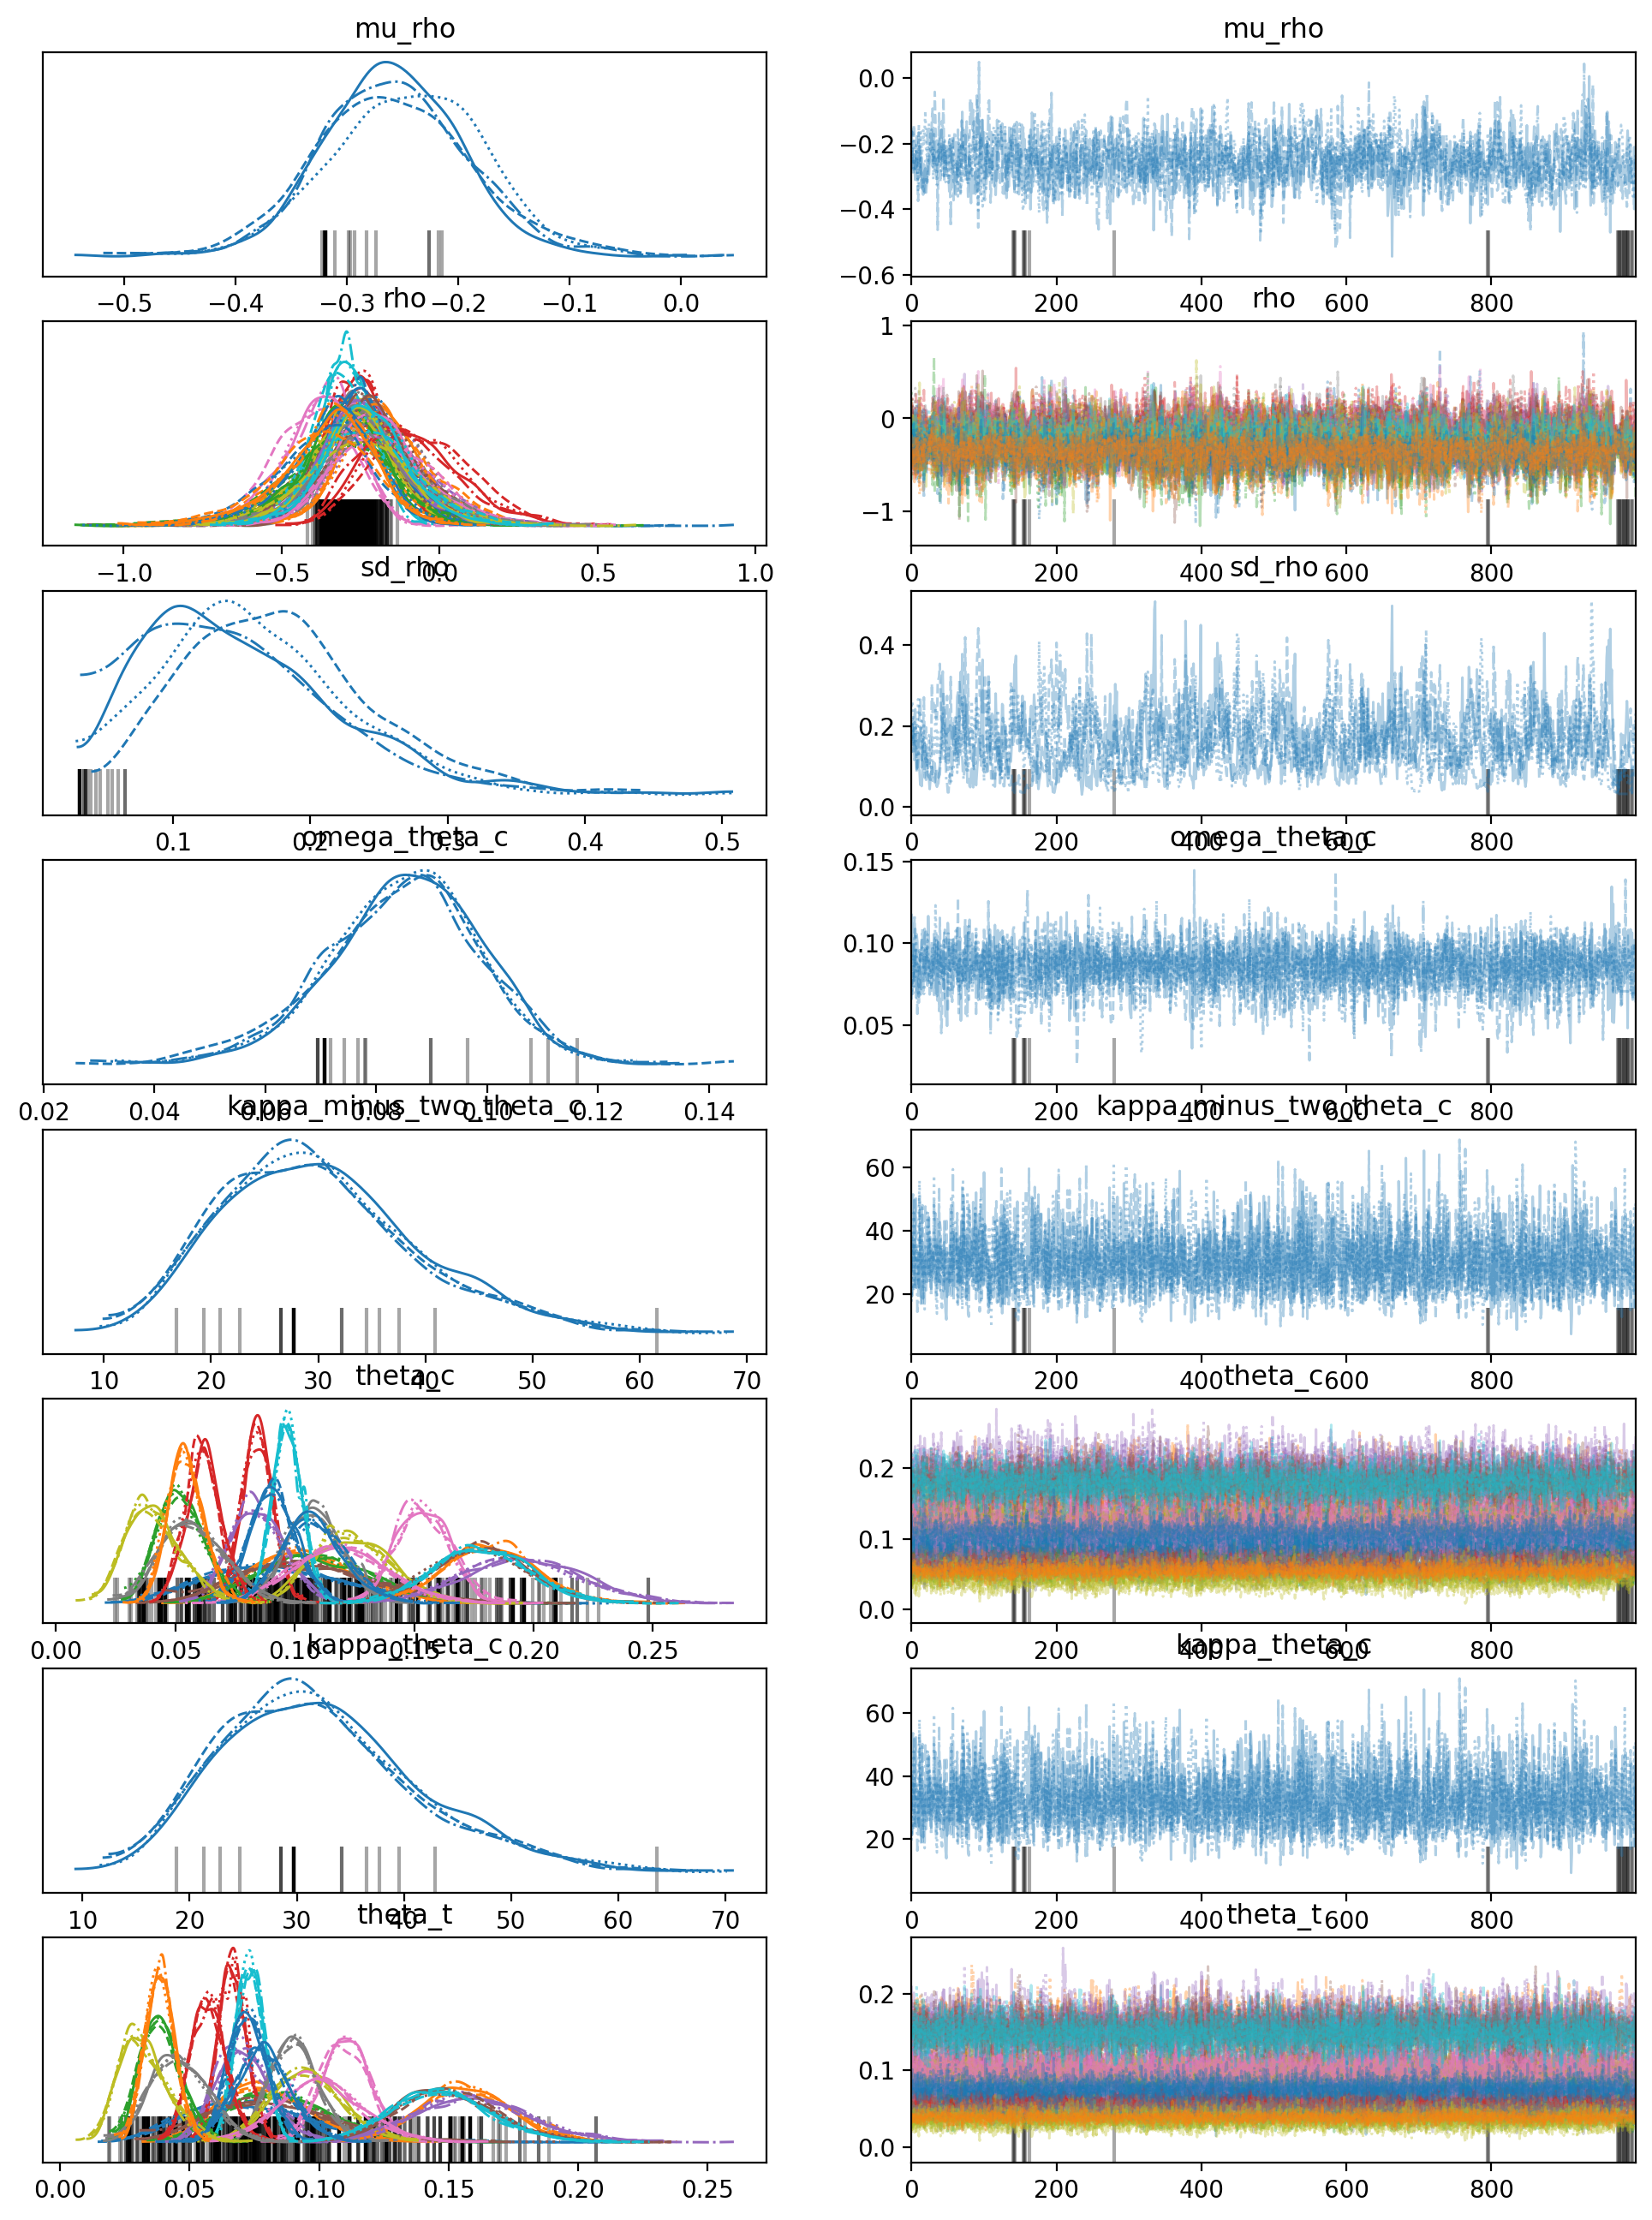

In [5]:
az.plot_trace(idata);

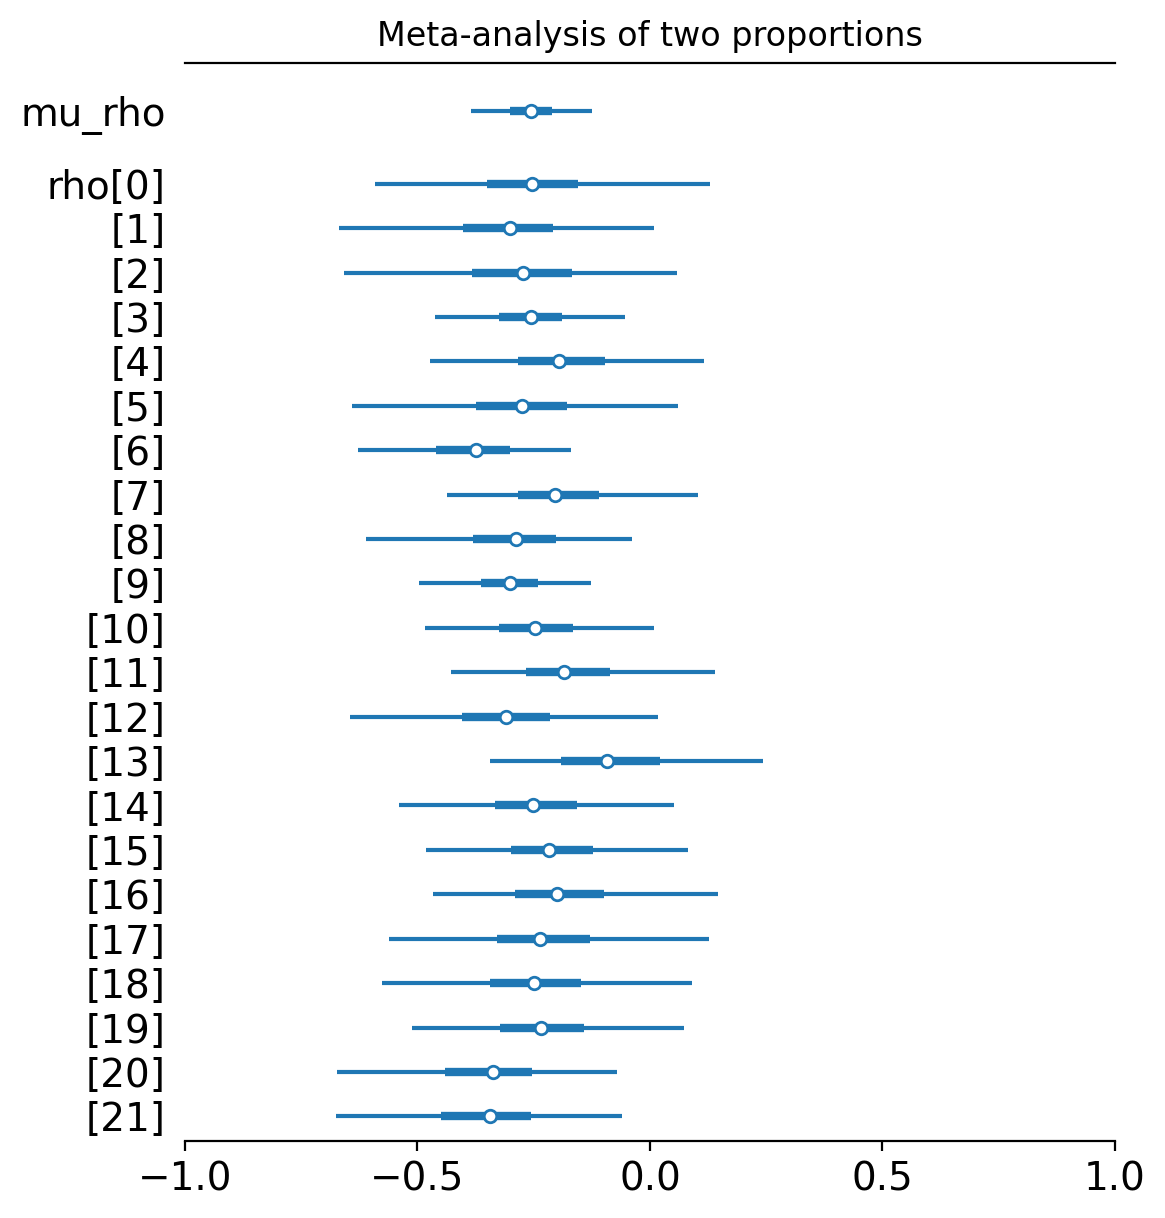

In [6]:
_, ax = plt.subplots(figsize=(6, 7))
az.plot_forest(idata, 
               var_names=["mu_rho", "rho"], 
               kind="forestplot",
               combined=True,
               ax=ax)
ax.set_xlim([-1, 1])
ax.set_title("Meta-analysis of two proportions");

In [7]:
az.summary(idata, var_names=["mu_rho", "rho"])

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_rho,-0.255,0.068,-0.386,-0.125,0.002,0.001,1060.0,1670.0,1.00
rho[0],-0.252,0.176,-0.591,0.130,0.003,0.003,2563.0,1892.0,1.01
rho[1],-0.313,0.167,-0.670,0.008,0.004,0.003,2205.0,2052.0,1.01
rho[2],-0.280,0.178,-0.658,0.059,0.004,0.003,2464.0,1837.0,1.01
rho[3],-0.255,0.104,-0.463,-0.054,0.002,0.001,2804.0,2465.0,1.00
rho[4],-0.186,0.148,-0.473,0.116,0.004,0.003,1786.0,2630.0,1.00
rho[5],-0.279,0.171,-0.640,0.060,0.004,0.003,2342.0,2169.0,1.01
rho[6],-0.384,0.118,-0.627,-0.170,0.003,0.002,1216.0,2408.0,1.01
rho[7],-0.194,0.136,-0.437,0.104,0.003,0.002,2103.0,2521.0,1.00
rho[8],-0.295,0.144,-0.610,-0.039,0.003,0.002,2498.0,2350.0,1.00


The estimated parameter values above are highly consistent with those reported in the Kruschke analysis using R and JAGS.

# New model (normal-normal from Rover 2020)

In [10]:
# Data from stroke meta-analysis
eff_size = np.array([0.334647179, -0.2997250305, -0.2428621299, -1.622743498, 
                     -0.2423718801, -1.06431894, 0.2937822071, -1.499113213, -0.8203,
                     -0.5974, -0.1137870633, 0.1822088181, -0.0935022265, -0.775408451,
                     -0.1736013005, -0.3385696316, -1.024715091, -0.08220616002, 
                     0.1098119513])
eff_size_se = np.array([0.450357143, 0.449693878, 0.587653061, 0.672704082, 0.461173469, 
                        0.477806122, 0.588571429, 0.660663265, 0.54372449, 1.1338, 0.507908163, 
                        0.354285714, 0.39244898, 0.445714286, 0.37867347, 0.3980102, 0.40923469, 
                        0.527244898, 0.816938776])
n_studies = len(eff_size)

In [21]:
# with pm.Model(coords={"studies": studies}) as model:
with pm.Model() as model_2:
    
    # Hyper-priors
    mu_theta = pm.Normal("mu_theta", mu=0, sigma=1)
    tau_theta = pm.Exponential("tau_theta", lam=1)

    # Priors
    theta = pm.Normal("theta", mu=mu_theta, sigma=tau_theta, shape=n_studies)

    # Likelihood
    y = pm.Normal('y', mu=theta, tau=1 / (eff_size_se**2), observed=eff_size)  # y_obs is empirical (mean) effect size of each study
    
    # Sample from the posterior
    idata_2 = pm.sample(n_draws=2000, target_accept=0.92)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_theta, tau_theta, theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


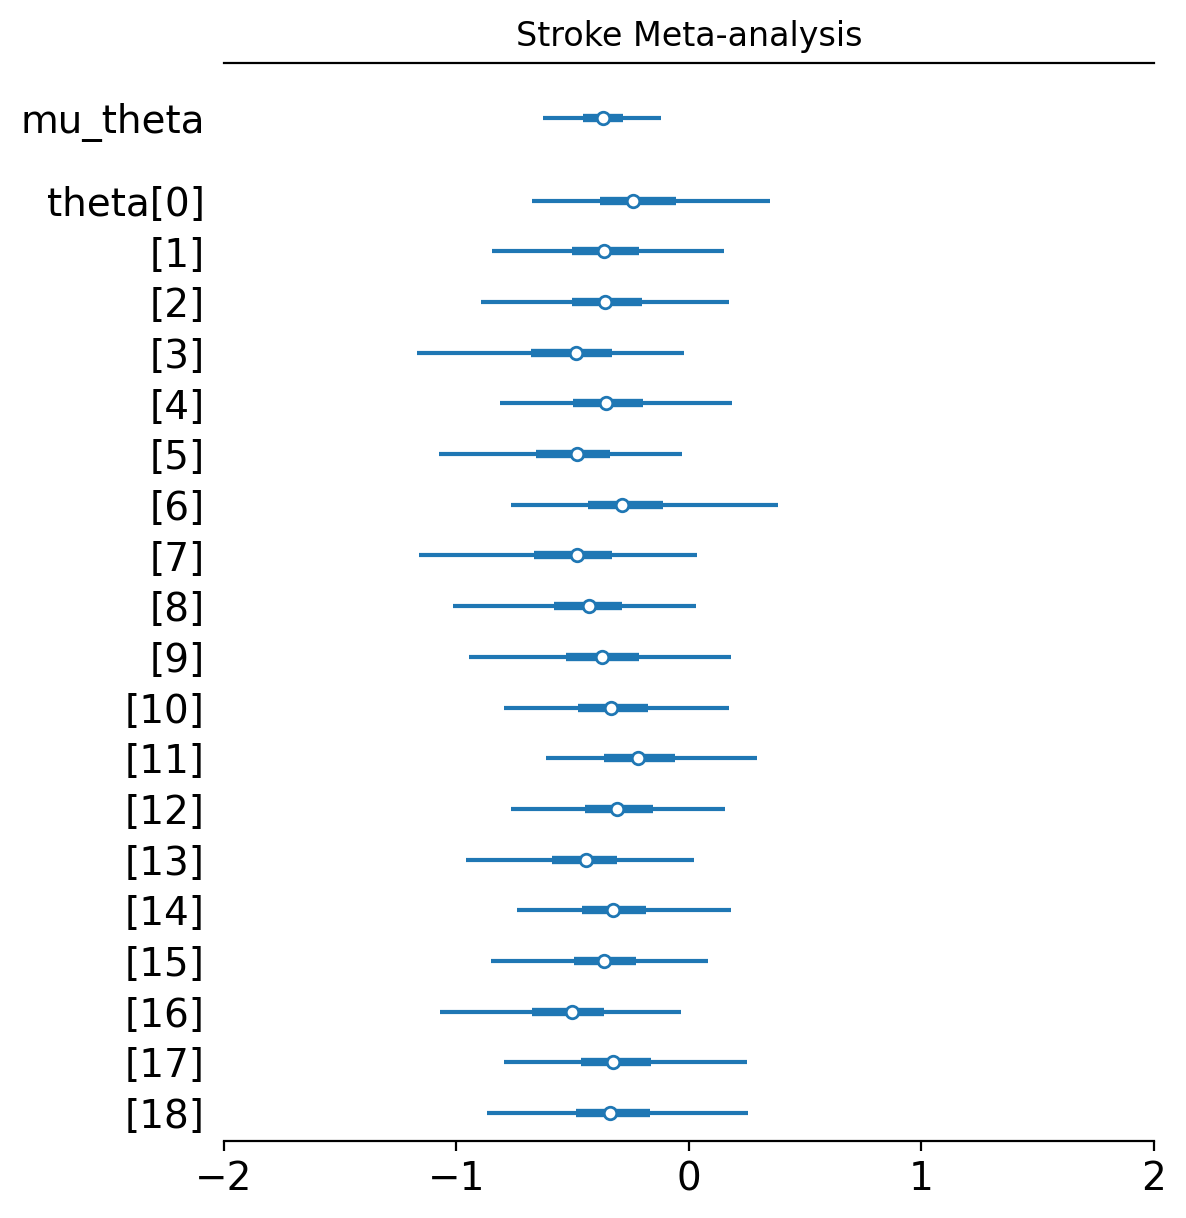

In [22]:
_, ax = plt.subplots(figsize=(6, 7))
az.plot_forest(idata_2, 
               var_names=["mu_theta", "theta"], 
               kind="forestplot",
               combined=True,
               ax=ax)
ax.set_xlim([-2, 2])
ax.set_title("Stroke Meta-analysis");

In [23]:
az.summary(idata_2, var_names=["mu_theta", "theta"])

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_theta,-0.369,0.129,-0.630,-0.119,0.004,0.003,831.0,757.0,1.00
theta[0],-0.204,0.260,-0.674,0.350,0.013,0.009,470.0,1654.0,1.01
theta[1],-0.360,0.243,-0.849,0.150,0.005,0.005,1933.0,1876.0,1.01
theta[2],-0.351,0.262,-0.896,0.173,0.005,0.004,2289.0,2202.0,1.01
theta[3],-0.527,0.297,-1.169,-0.019,0.010,0.007,873.0,1268.0,1.02
theta[4],-0.344,0.249,-0.813,0.186,0.005,0.004,2364.0,1819.0,1.01
theta[5],-0.516,0.269,-1.074,-0.031,0.009,0.006,966.0,1293.0,1.01
theta[6],-0.260,0.279,-0.765,0.385,0.008,0.005,1277.0,1964.0,1.01
theta[7],-0.523,0.301,-1.161,0.035,0.010,0.007,1081.0,1582.0,1.02
theta[8],-0.446,0.258,-1.013,0.030,0.007,0.005,1334.0,1291.0,1.02


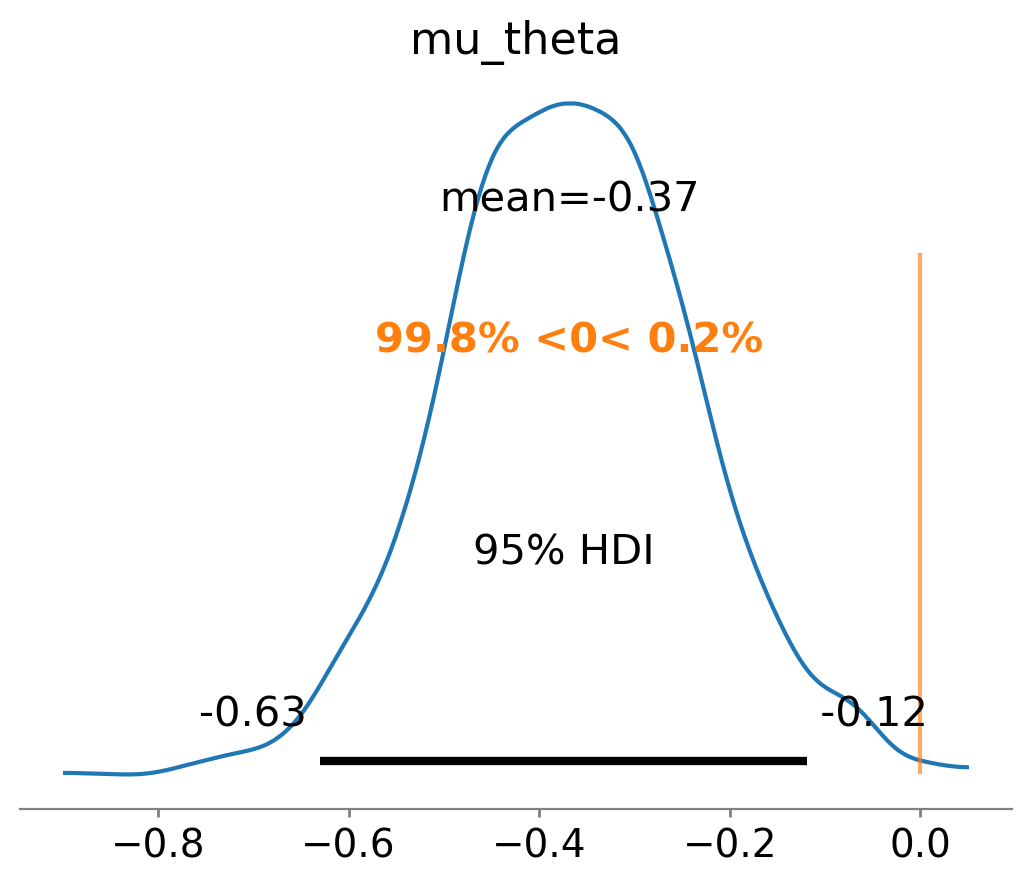

In [25]:
az.plot_posterior(idata_2, var_names=["mu_theta"], ref_val=0);

In [19]:
np.log10(2)

0.3010299956639812